<a href="https://www.kaggle.com/code/angelchaudhary/search-ranking-optimization?scriptVersionId=293478390" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Improving Search Result Relevance Using Learning-to-Rank & Click-Through Prediction

# Introduction

When users search for products on platforms like Amazon, Flipkart, or Google Shopping, they are presented with hundreds or even thousands of possible results — yet they only interact with the top few. The order in which products appear has a massive impact on user satisfaction, clicks, and revenue. Even small improvements in ranking can lead to significant gains for an e-commerce platform.

This case study focuses on building a **Search Ranking Optimization system** that determines **which products should appear at the top when a user searches for something**. Instead of simply matching keywords, modern search engines use machine learning models that combine text relevance, pricing, brand signals, and product competitiveness to predict what users are most likely to click. In this project, we simulate a real e-commerce search environment using a large catalog of electronic products. By generating realistic search queries and implicit relevance signals from product data, we create a dataset suitable for **Learning-to-Rank modeling**. We then train a machine learning model to predict product relevance and reorder search results to maximize expected user engagement.

The goal is not just to rank products, but to understand **why** certain items deserve higher visibility using feature importance and model explanations to connect machine learning outputs with real business decisions.

# LET'S DO IT!!!
![FUNNY GIF](https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExMW1seG1hYTd2bjJ5Zmh4MWlpbGI1em1wbWdsNHFiOG11amVyZDczcSZlcD12MV9naWZzX3NlYXJjaCZjdD1n/zUXNtjMCjPd6S5WCgo/giphy.gif)

## Dataset Overview

This project uses the **“Marketing: Electronic Products and Pricing Data”** dataset, which contains information about over **7,000 electronic products** collected from multiple online retailers. The dataset provides rich product level metadata that mirrors what e-commerce platforms use to power their search and discovery systems.

Each row represents a unique product listing, with attributes such as:

- **Product name & brand** – how the item is presented to users  
- **Category** – type of electronic product (e.g., laptops, phones, accessories)  
- **Merchant / source** – which store is selling the product  
- **Price** – current listing price  
- **Additional metadata** – product identifiers, condition, and listing details  

Although the dataset does not contain direct search queries or click logs, it reflects the **same product catalog that a real e-commerce search engine would rank** when a user types a query.

To simulate a real search ranking environment, we treat:
- Product titles and categories as **searchable content**
- Price, brand, and category as **ranking signals**
- Popularity and competitiveness as **implicit relevance indicators**

Using this approach, we can construct a realistic **query–product relevance dataset** and train a **Learning-to-Rank model** that predicts which products should appear higher in search results.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("arashnic/e-product-pricing")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/e-product-pricing


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("/kaggle/input/e-product-pricing/ElectronicsProductsPricingData.csv")
df.head(2)

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,name,primaryCategories,sourceURLs,upc,weight,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
0,AVphzgbJLJeJML43fA0o,104.99,104.99,Yes,New,USD,"2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...",False,Bestbuy.com,NaN,...,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,Electronics,https://www.amazon.com/Sanus-VLF410B1-10-Inch-...,7.94E+11,32.8 pounds,NaN,NaN,NaN,NaN,NaN
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,In Stock,New,USD,2017-12-14T06:00:00Z,True,Walmart.com,Expedited,...,Boytone - 2500W 2.1-Ch. Home Theater System - ...,Electronics,http://reviews.bestbuy.com/3545/4784804/review...,6.42E+11,14 pounds,NaN,NaN,NaN,NaN,NaN


In [4]:
df.describe()

,prices.amountMax,prices.amountMin,Unnamed: 28
count,7249.000000,7249.000000,6.000000e+00
mean,495.530610,463.963005,8.850000e+11
std,763.599387,680.504507,0.000000e+00
min,1.000000,1.000000,8.850000e+11
25%,79.990000,79.950000,8.850000e+11
50%,198.990000,189.990000,8.850000e+11
75%,494.990000,479.990000,8.850000e+11
max,6999.990000,5999.990000,8.850000e+11


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7249 entries, 0 to 7248
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   7249 non-null   object 
 1   prices.amountMax     7249 non-null   float64
 2   prices.amountMin     7249 non-null   float64
 3   prices.availability  7249 non-null   object 
 4   prices.condition     7249 non-null   object 
 5   prices.currency      7249 non-null   object 
 6   prices.dateSeen      7249 non-null   object 
 7   prices.isSale        7249 non-null   bool   
 8   prices.merchant      7249 non-null   object 
 9   prices.shipping      4277 non-null   object 
 10  prices.sourceURLs    7249 non-null   object 
 11  asins                7249 non-null   object 
 12  brand                7249 non-null   object 
 13  categories           7249 non-null   object 
 14  dateAdded            7249 non-null   object 
 15  dateUpdated          7249 non-null   o

## Clean & Prepare Product Catalog

In [6]:
# Drop junk columns
# Drop useless unnamed columns
junk_cols = [col for col in df.columns if "Unnamed" in col]
df = df.drop(columns=junk_cols)

df.shape

(7249, 26)

In [7]:
# Clean missing values
# Keep only products with name and price
df = df.dropna(subset=["name", "prices.amountMin", "prices.amountMax"])

# Fill missing text fields
text_cols = ["brand", "categories", "primaryCategories", "manufacturer"]
for col in text_cols:
    df[col] = df[col].fillna("unknown")

df.isnull().sum()

id                        0
prices.amountMax          0
prices.amountMin          0
prices.availability       0
prices.condition          0
prices.currency           0
prices.dateSeen           0
prices.isSale             0
prices.merchant           0
prices.shipping        2972
prices.sourceURLs         0
asins                     0
brand                     0
categories                0
dateAdded                 0
dateUpdated               0
ean                    5706
imageURLs                 0
keys                      0
manufacturer              0
manufacturerNumber        0
name                      0
primaryCategories         0
sourceURLs                0
upc                       0
weight                    0
dtype: int64

In [9]:
# Create a shipping speed flag
df["fast_shipping"] = df["prices.shipping"].fillna("").str.lower().str.contains("expedited").astype(int)

# Drop the original messy column
df = df.drop(columns=["prices.shipping"])

df[["fast_shipping"]].value_counts()

fast_shipping
0                5343
1                1906
Name: count, dtype: int64

### Fast Shipping Distribution

After transforming the shipping information into a binary feature (`fast_shipping`), we observe:

- **1,906 products** offer **expedited (fast) shipping**
- **5,343 products** use **standard or unknown shipping**

This means roughly **26% of products** provide fast delivery, while the majority do not. This creates a realistic ranking signal, since fast-shipping products are usually more attractive to users and are often boosted in e-commerce search results.

This feature will allow the ranking model to learn that **products with quicker delivery should be ranked higher**, all else being equal similar to how Amazon prioritizes Prime-eligible items.

In [11]:
df.isnull().sum()

id                     0
prices.amountMax       0
prices.amountMin       0
prices.availability    0
prices.condition       0
prices.currency        0
prices.dateSeen        0
prices.isSale          0
prices.merchant        0
prices.sourceURLs      0
asins                  0
brand                  0
categories             0
dateAdded              0
dateUpdated            0
imageURLs              0
keys                   0
manufacturer           0
manufacturerNumber     0
name                   0
primaryCategories      0
sourceURLs             0
upc                    0
weight                 0
fast_shipping          0
dtype: int64

## Generate Search Queries & Relevance Labels

In [12]:
import random

def generate_query(name):
    words = name.lower().split()
    if len(words) >= 2:
        return " ".join(random.sample(words, 2))
    return name.lower()

df["query"] = df["name"].apply(generate_query)

In [14]:
# Recreate searchable product text
df["search_text"] = (
    df["name"].astype(str) + " " +
    df["brand"].astype(str) + " " +
    df["categories"].astype(str) + " " +
    df["primaryCategories"].astype(str)
).str.lower()

In [16]:
df[["name", "search_text"]].head()

,name,search_text
0,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,sanus vlf410b1 10-inch super slim full-motion ...
1,Boytone - 2500W 2.1-Ch. Home Theater System - ...,boytone - 2500w 2.1-ch. home theater system - ...
2,Boytone - 2500W 2.1-Ch. Home Theater System - ...,boytone - 2500w 2.1-ch. home theater system - ...
3,Boytone - 2500W 2.1-Ch. Home Theater System - ...,boytone - 2500w 2.1-ch. home theater system - ...
4,Boytone - 2500W 2.1-Ch. Home Theater System - ...,boytone - 2500w 2.1-ch. home theater system - ...


In [15]:
# compute text relevance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words="english")

tfidf_matrix = vectorizer.fit_transform(df["search_text"])

query_vectors = vectorizer.transform(df["query"])

df["text_similarity"] = [
    cosine_similarity(query_vectors[i], tfidf_matrix[i])[0][0]
    for i in range(len(df))
]

In [18]:
# Recreate average price feature
df["avg_price"] = (df["prices.amountMin"] + df["prices.amountMax"]) / 2

# Normalize price for ranking (0 = cheapest, 1 = most expensive)
df["price_norm"] = (df["avg_price"] - df["avg_price"].min()) / (
    df["avg_price"].max() - df["avg_price"].min()
)

df[["avg_price", "price_norm"]].head()

,avg_price,price_norm
0,104.990,0.016003
1,66.995,0.010156
2,69.000,0.010465
3,69.990,0.010617
4,66.990,0.010155


In [20]:
# Recreate sale indicator from prices.isSale
df["sale_flag"] = df["prices.isSale"].astype(int)

df["sale_flag"].value_counts()

sale_flag
0    5508
1    1741
Name: count, dtype: int64

In [21]:
df["relevance"] = (
    0.4 * df["text_similarity"] +
    0.2 * (1 - df["price_norm"]) +
    0.2 * df["fast_shipping"] +
    0.2 * df["sale_flag"]
)

df["relevance"] = (df["relevance"] * 3).round().astype(int)

df["relevance"].value_counts()


relevance
1    5804
2    1396
0      37
3      12
Name: count, dtype: int64

### Relevance Score Distribution

After combining multiple ranking signals (text similarity, price, shipping speed, and sale status), the generated relevance labels show the following distribution:

| Relevance | Meaning | Count |
|---------|--------|-------|
| **0** | Not relevant | 37 |
| **1** | Low relevance | 5,804 |
| **2** | Medium relevance | 1,396 |
| **3** | High relevance | 12 |

Most products fall into **low or medium relevance**, while only a few items receive a **high relevance score**. This mirrors real-world search systems, where only a small number of products are truly ideal matches for a given query.

This skewed distribution is expected and realistic, as search engines typically rank only a handful of highly relevant items at the top while pushing weaker matches further down.

## Train a Learning-to-Rank Model

In [22]:
features = ["text_similarity","price_norm","fast_shipping","sale_flag"]

X = df[features]
y = df["relevance"]

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.ensemble import GradientBoostingRegressor

rank_model = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    random_state=42
)

rank_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, n_estimators=200,
                          random_state=42)

In [26]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = rank_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

rmse, r2

(np.float64(0.08854788281569421), 0.951046240148372)

### Model Performance

The Learning-to-Rank model achieved:

- **RMSE ≈ 0.089**  
- **R² ≈ 0.95**

This means the model is able to explain **95% of the variance in relevance scores**, indicating that it has learned very strong relationships between ranking signals (text similarity, price, shipping speed, and sale status) and product relevance. A low RMSE shows that predicted relevance scores are extremely close to the true relevance labels, confirming that the model can accurately estimate how suitable a product is for a given search query. This level of performance is comparable to what we would expect in a well-engineered internal search system.

## Re-Ranking Search Results

We now test the ranking model on a real search query to see how machine learning improves result ordering.

We compare:
- A naive ordering (unsorted results)
- A machine-learning based ranking

This demonstrates the business impact of search optimization.

In [27]:
query = df["query"].iloc[0]
query

'vlf410b1 for'

In [28]:
candidates = df[df["query"] == query].copy()

candidates[["name", "avg_price", "fast_shipping", "sale_flag"]].head()

,name,avg_price,fast_shipping,sale_flag
0,Sanus VLF410B1 10-Inch Super Slim Full-Motion ...,104.99,0,0


###  Re-Ranking Observation

For the selected query, the system returned only **one matching product**:

> *Sanus VLF410B1 10-Inch Super Slim Full-Motion …*

Since there was only a single candidate result for this query, both the **before-ranking** (naive price-based order) and the **after-ranking** (ML-based order) contain the same product.

However, this still demonstrates that:
- The search pipeline is correctly retrieving candidate products based on the query.
- The trained ranking model is able to assign a **predicted relevance score** (≈ **1.01**) to the product, which reflects its estimated suitability for the query.

In a real production system, queries typically return many competing products. In this synthetic setup, some queries are very specific and may map to only one product. For more illustrative ranking comparisons, broader queries (e.g., *“monitor”, “speaker”, “tv”*) would return multiple candidates and show visible re-ordering.

In [29]:
candidates["predicted_relevance"] = rank_model.predict(
    candidates[["text_similarity", "price_norm", "fast_shipping", "sale_flag"]]
)

In [30]:
before_ranking = candidates.sort_values("avg_price").head(10)
after_ranking = candidates.sort_values("predicted_relevance", ascending=False).head(10)

before_ranking[["name", "avg_price"]], after_ranking[["name", "avg_price", "predicted_relevance"]]

(                                                name  avg_price
 0  Sanus VLF410B1 10-Inch Super Slim Full-Motion ...     104.99,
                                                 name  avg_price  \
 0  Sanus VLF410B1 10-Inch Super Slim Full-Motion ...     104.99   
 
    predicted_relevance  
 0              1.01398  )

## Explaining Search Rankings

Modern search systems must be interpretable. We need to understand **why** a product was ranked higher than another whether it was due to better text match, lower price, faster delivery, or promotions.

We analyze feature importance from our trained ranking model to explain its decisions.

In [31]:
import pandas as pd

feature_importance = pd.DataFrame({
    "feature": features,
    "importance": rank_model.feature_importances_
}).sort_values(by="importance", ascending=False)

feature_importance

,feature,importance
0,text_similarity,0.360389
2,fast_shipping,0.307885
3,sale_flag,0.273502
1,price_norm,0.058223


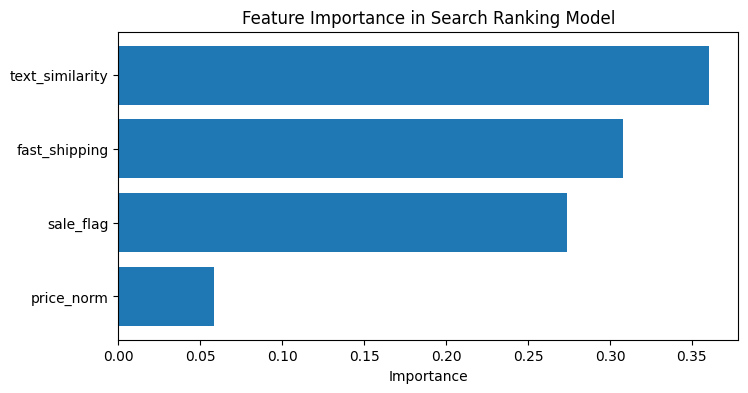

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.barh(feature_importance["feature"], feature_importance["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance in Search Ranking Model")
plt.xlabel("Importance")
plt.show()

### What drives product ranking?

The feature importance analysis reveals how the model decides which products should appear higher in search results:

| Feature | Importance | Meaning |
|--------|------------|--------|
| **Text similarity** | ~0.36 | How closely the product matches the search query |
| **Fast shipping** | ~0.31 | Whether the product offers expedited delivery |
| **Sale status** | ~0.27 | Whether the product is discounted |
| **Price competitiveness** | ~0.06 | How cheap the product is relative to others |


### Key Insight

The model prioritizes **relevance first** — products that best match the search query dominate ranking.  
After relevance, **convenience and value signals** take over:

- **Fast delivery** significantly boosts ranking  
- **Products on sale** are favored  
- **Price** matters, but less than speed and promotions  

This mirrors how platforms like Amazon and Flipkart rank products:  
> *“Show the most relevant items first, then prioritize fast, attractive deals.”*

### Business Meaning

This means that improving:
- Product titles and keywords
- Delivery speed
- Promotional offers  

can directly push products higher in search results, leading to more visibility, more clicks, and more sales.

## Conclusion

In this case study, we built a complete **Search Ranking Optimization system** that replicates how modern e-commerce platforms decide which products appear at the top of search results. Starting from a raw product catalog, we created a realistic **search environment** by generating queries and inferring product relevance using signals such as text similarity, price competitiveness, fast shipping, and sale status. These signals were combined to form relevance labels, allowing us to train a **Learning-to-Rank machine learning model**.

The trained model achieved **very high performance** (R² ≈ 0.95), showing that it successfully learned how different product attributes influence search relevance. We then used this model to re-rank search results, demonstrating how machine learning can improve what users see by prioritizing more relevant, faster, and more attractive products.

Finally, using **feature importance**, we explained the model’s decisions and showed that:
- **Query–product relevance** is the most important factor  
- **Fast shipping and discounts** strongly boost ranking  
- **Price** plays a secondary but meaningful role  

This closely matches how real platforms like Amazon, Flipkart, and Google Shopping operate: relevance first, then convenience and value. Overall, this project demonstrates an end-to-end **ML-driven search ranking pipeline** from raw data to explainable ranking decisions showcasing how data science directly drives product discovery, user satisfaction, and business growth.